In [1]:
import numpy as np
import matplotlib
import datetime
import matplotlib.pyplot as plt

def create_data(n, d, n_informative=0, bias=None):
    """
    The functions returns:
     X - a nxd matrix of n samples with d normaly distrbuted features.
     Y - a binary random response vector
    
    We bias to the first n_informative features to correlate them with Y, so
    They are no longer normally distrbuted.
    """
    X = np.random.normal(0, 1, (n,d))
    Y = np.random.rand(n) > 0.5
    
    if n_informative > 0:
        X[:, :n_informative] += np.tile(bias * Y, (n_informative,1)).T
    return X, Y


In [2]:
from scipy.stats import pearsonr

def compute_correlations(X, Y):
    """
    compute correlaction of each column in X with Y
    """
    n,d = X.shape
    return np.array([pearsonr(X[:,i], Y)[0] for i in xrange(d)])

def naive_feature_selection(X_train, Y_train, X_holdout, Y_holdout, n_features):
    """
    Naive feature selection approach.
    We first compute the correlation of each feature in X_train with Y_train.
    We then select the top n_features that had the strongest correlation as long,
    as they were also correlated on the holdout set, and the sign of the coorelation on both
    set match.
    """
    # compute all correlation stats
    all_r_train = compute_correlations(X_train, Y_train)
    all_r_holdout = compute_correlations(X_holdout, Y_holdout)

    # sort correlation by magnitude
    sorted_train_idx = np.abs(all_r_train).argsort()[::-1]

    # loop over features
    selected_features = []
    i_feature = 0
    while len(selected_features) < n_features:
        feature_idx = sorted_train_idx[i_feature]
        r_train = all_r_train[feature_idx]
        r_holdout = all_r_holdout[feature_idx]
        #if the feature also correlate 
        if (r_holdout > 1. / np.sqrt(n)) and \
            (r_holdout * r_train > 0):
            selected_features.append(feature_idx)
        i_feature +=1
    return selected_features


def noise(sigma):
    """
    geneartes gaussian noise
    """
    return np.random.randn() * sigma


def thresholdout(train_stat, holdout_stat, threshold, tolerance):
    """
    A simple version of thresholdout algorithm. 
    The full version uses Laplase noise, Budget and some other extra stuff
    """
    if np.abs(train_stat - holdout_stat) > threshold + noise(tolerance):
        return holdout_stat + noise(tolerance)
    else:
        return train_stat
    
def feature_selection(X_train, Y_train, X_holdout, Y_holdout, n_features, 
                                   method, **kwargs):
    """
    thresholdout features selection.
    Similar to the naive features selection method (see documantion above), only with thresholdout
    """
    # compute all correlation stats
    all_r_train = compute_correlations(X_train, Y_train)
    all_r_holdout = compute_correlations(X_holdout, Y_holdout)
    
    # sort correlation by magnitude
    sorted_train_idx = np.abs(all_r_train).argsort()[::-1]

    # loop over features
    selected_features = []
    i_feature = 0
    while len(selected_features) < n_features:
        feature_idx = sorted_train_idx[i_feature]
        r_train = all_r_train[feature_idx]
        if method.lower() == "naive":
            r_holdout = all_r_holdout[feature_idx]
        elif method.lower() == 'thresholdout':
            r_holdout = thresholdout(train_stat=r_train, 
                                     holdout_stat=all_r_holdout[feature_idx], 
                                     **kwargs)
        else:
            raise ValueError('Unknown method: %s' % method)
        if (r_holdout > 0.5 / np.sqrt(n)) and \
            (r_holdout * r_train > 0):
            selected_features.append(feature_idx)
        i_feature +=1
    return selected_features


In [3]:
from sklearn.linear_model import LogisticRegression
import pandas as pd

def run_lr(selected_features, X_train, Y_train, X_holdout, Y_holdout, X_fresh, Y_fresh, method, **kwargs):
    """
    Train and score a logistic regression model
    """
    lr = LogisticRegression()
    lr.fit(X_train[:,selected_features], Y_train)
    res = {}
    res['train'] = lr.score(X_train[:,selected_features], Y_train)
    holdout_score = lr.score(X_holdout[:,selected_features], Y_holdout)
    if method.lower() == 'thresholdout':
        res['holdout'] = thresholdout(train_stat=res['train'], 
                                      holdout_stat=holdout_score, 
                                      **kwargs)
    elif method.lower() == 'naive':
        res['holdout'] = holdout_score
    else:
        raise ValueError("unknown method: %s" % method)
    res['fresh'] = lr.score(X_fresh[:,selected_features], Y_fresh)
    return pd.Series(res)


In [4]:

def iter_n_features(X_train, Y_train, X_holdout, Y_holdout, X_fresh, Y_fresh, method, **kwargs):
    res = {}
    for n_features in [1, 5] + range(10, 200, 10):
        selected_features = feature_selection(X_train, Y_train, X_holdout, Y_holdout, 
                                                   n_features=n_features, method=method, **kwargs)
        res[n_features] = run_lr(selected_features, X_train, Y_train, X_holdout, Y_holdout, X_fresh, Y_fresh,
                                 method, **kwargs)

    return pd.DataFrame(res)

In [24]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def run_simulation(n, d, n_informative, threshold, tolerance, seed):
    """
    run naive and thresholdout simulations
    """
    np.random.seed(seed)
    X_train, Y_train = create_data(n, d, n_informative, bias)
    X_holdout, Y_holdout = create_data(n, d, n_informative, bias)
    X_fresh, Y_fresh = create_data(n, d, n_informative, bias)

    print "Simulating Naive."
    naive_res = iter_n_features(X_train, Y_train, X_holdout, Y_holdout, X_fresh, Y_fresh, method='naive')
    print "Simulating Thresholdout."
    thresholdout_res = iter_n_features(X_train, Y_train, X_holdout, Y_holdout, X_fresh, Y_fresh,
                                       method='thresholdout', 
                                       threshold=threshold, tolerance=tolerance)
    print "Done simulating."
    return naive_res, thresholdout_res

def add_jitter(res):
    # we jitter the holdout results for siplay purposes since they sometime identical to the trainin results
    res = res.copy()
    n_experiments = len(thresholdout_res.columns)
    res.ix['holdout'] += np.random.randn(n_experiments) * 0.003
    return res

def plot_naive_and_thresholdout(naive_res, thresholdout_res):   
    """
    Display the results of the naive and thresholdout simulations side-by-side
    """
    
    thresholdout_res = add_jitter(thresholdout_res)
    
    # plotting
    fig, axes = plt.subplots(1,2, figsize=(14,7))
    ylim_  = (0.45, 0.75)
    xlim_ = (-5, naive_res.columns.max() + 5)
    for ax, res in zip(axes, [naive_res, thresholdout_res]):
        res.T.plot(style='-o', ax=ax, xlim=xlim_, ylim=ylim_)

    axes[0].set_title('Naive')
    axes[1].set_title('Thresholdout')



# Experiments with no informative features

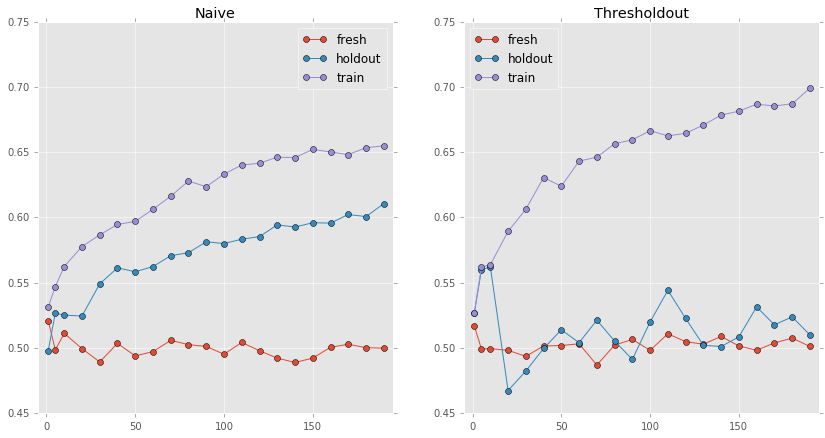

In [25]:
%matplotlib inline
n = 3000
d = 3000
bias = 10.0/np.sqrt(n)
n_informative = 0
threshold = 4./np.sqrt(n)
tolerance = threshold / 4.
naive_res, thresholdout_res = run_simulation(n, d, n_informative, threshold, tolerance, seed=1) 
plot_naive_and_thresholdout(naive_res, thresholdout_res)

# Experiments with 10 informative features

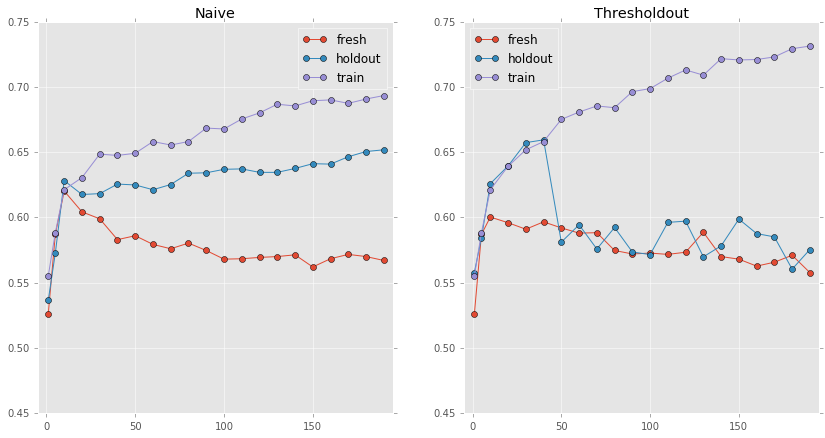

In [26]:
%matplotlib inline
n = 3000
d = 3000
bias = 10.0/np.sqrt(n)
n_informative = 10
threshold = 4./np.sqrt(n)
tolerance = threshold / 4.
naive_w_info_res, thresholdout_w_info_res = run_simulation(n, d, n_informative, threshold, tolerance, seed=1) 
plot_naive_and_thresholdout(naive_w_info_res, thresholdout_w_info_res)

# The affect of the threshold

In [ ]:
thresholds = np.array([0.01, 1., 4, 50.]) / np.sqrt(n)
np.random.seed(1)
n = 3000
d = 3000
bias = 10.0/np.sqrt(n)
n_informative = 0
X_train, Y_train = create_data(n, d, n_informative, bias)
X_holdout, Y_holdout = create_data(n, d, n_informative, bias)
X_fresh, Y_fresh = create_data(n, d, n_informative, bias)

threshold_exp = {}
for threshold in thresholds:
    experiment = iter_n_features(X_train, Y_train, X_holdout, Y_holdout, X_fresh, Y_fresh,
                                       method='thresholdout', 
                                       threshold=threshold, tolerance=threshold/4.)
    threshold_exp[threshold] = experiment

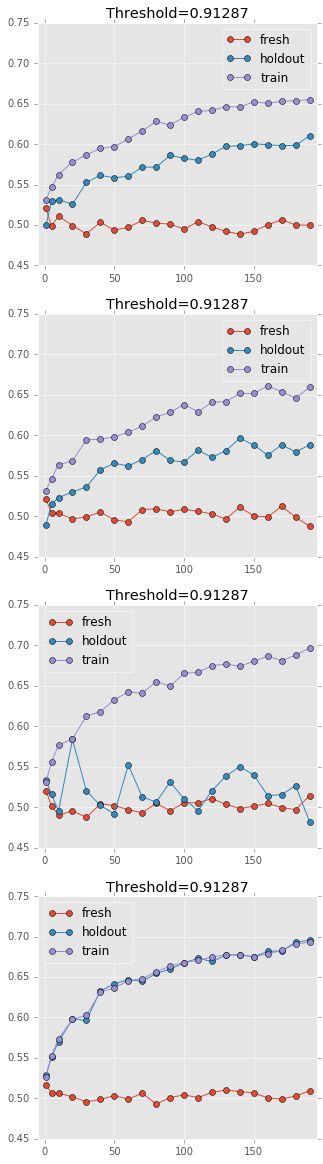

In [42]:
fig, axes = plt.subplots(len(thresholds), 1, figsize=(5, 20))
for i in xrange(len(thresholds)):    
    experiment = threshold_exp[thresholds[i]]
    experiment = add_jitter(experiment)
    ax = axes[i]
    experiment.T.plot(style='-o', ax=ax)
    ax.set_title("Threshold={:.5f}".format(threshold))
    ax.set_ylim(0.45, 0.75)
    ax.set_xlim(-5, experiment.columns.max() + 5)